<a href="https://colab.research.google.com/github/pioneerbluepanthers/computationaldrug/blob/main/rohit_comparing_binarization_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
! pip install shap

In [ ]:
# data science
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import classification_report
import keras

# figure generation
import matplotlib.pyplot as plt

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_df = pd.read_csv("/content/drive/MyDrive/Rohit Work/social_data.csv", index_col=0)

In [ ]:
base_df.head()

In [ ]:
base_df.sample

# Data processing

In [ ]:
# KNN imputation

def ComorbidImputation(df):
  #df_col_f=['patient_id']
  df_col = list(df.columns)
  df_index = df.index

  # initialize KNN imputer with 2 neighbors
  imputer=KNNImputer(n_neighbors=2)
  # make a copy of input dataframe
  temp_df = df.copy()
  # change the index to numerical values
  temp_df.reset_index(inplace=True)
  temp_df.drop(columns=temp_df.columns[0], inplace=True)
  #Compute KNN fit transform to impute the data
  new_temp_df = pd.DataFrame(imputer.fit_transform(temp_df.reset_index()))
  #drop the extra first column
  new_temp_df.drop(columns=new_temp_df.columns[0], inplace=True)
  #set the column and index values
  new_temp_df.columns=df_col
  new_temp_df.index = df_index
  imputed_df=new_temp_df.copy()
  #sort the dataframe columns in alphbetical order
  imputed_df=imputed_df.reindex(sorted(imputed_df.columns), axis=1)

  return imputed_df

In [ ]:
# Simple Imputer

def ComorbidImputationSimple(df):
   df_col = list(df.columns)
   imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
   imputed_df = pd.DataFrame(imputer.fit_transform(df))
   imputed_df.columns=df_col
   imputed_df.index=df.index
   #print(imputed_df)

   return imputed_df



In [ ]:
# Iterative Imputer

def ComorbidImputationIterative(df):
  df_col = list(df.columns)
  imputer = IterativeImputer(random_state=0)
  imputed_df = pd.DataFrame(imputer.fit_transform(df))
  imputed_df.columns=df_col
  imputed_df.index=df.index
  #print(imputed_df)
  return imputed_df


In [ ]:
from pandas.core.computation.pytables import com
# binarize comorbidities

# use: simply pass in the sociodemographic (or with binarized social risk factors)
# data frame. The function will return another dataframe containing all other
# relevant information and binarized comorbidities

def BinarizeComorbidities(df, column="comorbidity"):
  # get list of unique entries
  entries = df.loc[:, column].unique()

  # get unique list of conditions
  conditions = []
  for i in entries:
    try:
      subList = i.split(", ")
      for k in subList:
        conditions.append(k)
    except:
      pass


  uniqueConditions = list(set(conditions))

  # set up sub_df (to be appended) - columns are each condition
  comor_df = pd.DataFrame(index=df.index, columns=uniqueConditions, data=0)

  # populate the df with binary (0 = no, 1 = yes)
  for patient in df.index:
    comorbidity = df.loc[patient, "comorbidity"]
    try:
      comorbidityList = comorbidity.split(", ")
      for i in comorbidityList:
        comor_df.loc[patient, i] = 1
    except:
      for i in comor_df.columns:
        comor_df.loc[patient, i] = np.nan

  # remove comorbidity from original df
  concat_df = df.copy()
  concat_df.drop(columns=["comorbidity"], inplace=True)


  #copy it temp variable
  temp_df = comor_df.copy()
  #impute the missing values
  comor_temp = ComorbidImputation(temp_df)
  #comor_temp = ComorbidImputationSimple(temp_df)
  #comor_temp = ComorbidImputationIterative(temp_df)
  # concatenate the dfs
  #fin_df = pd.concat([concat_df, comor_df], axis=1)
  fin_df = pd.concat([concat_df, comor_temp], axis=1)

  # return the final df
  return fin_df

In [ ]:
# binarize social risk factors

# use: simply pass in the sociodemographic (or with binarized comorbidities)
# data frame. The function will return another dataframe containing all other
# relevant information and binarized comorbidities

def BinarizeSocialRisk(df, column="social_risk_factors"):
  # get list of unique entries
  entries = df.loc[:, column].unique()

  # get unique list of conditions
  conditions = []
  for i in entries:
    try:
      subList = i.split(", ")
      for k in subList:
        conditions.append(k)
    except:
      pass


  uniqueConditions = list(set(conditions))

  # set up sub_df (to be appended) - columns are each condition
  socialRisk_df = pd.DataFrame(index=df.index, columns=uniqueConditions, data=0)

  # populate the df with binary (0 = no, 1 = yes)
  for patient in df.index:
    socialRisk = df.loc[patient, column]
    try:
      socialRiskList = socialRisk.split(", ")
      for i in socialRiskList:
        socialRisk_df.loc[patient, i] = 1
    except:
      for i in socialRisk_df.columns:
        socialRisk_df.loc[patient, i] = np.nan

  # remove comorbidity from original df
  concat_df = df.copy()
  concat_df.drop(columns=[column], inplace=True)

  # concatenate the dfs
  fin_df = pd.concat([concat_df, socialRisk_df], axis=1)

  # return the final df
  return fin_df

In [ ]:
bincomorbid_df = BinarizeComorbidities(base_df)

In [36]:
#display(bincomorbid_df[bincomorbid_df.HIV.between(0,1, inclusive='neither')])
display(bincomorbid_df.columns)
#display(bincomorbid_df.loc[:,'outcome':'Anemia'])

Index(['identifier', 'registration_date', 'age_of_onset', 'gender', 'country',
       'education', 'employment', 'number_of_children',
       'number_of_daily_contacts', 'case_definition', 'diagnosis_code',
       'type_of_resistance', 'bmi', 'social_risk_factors', 'outcome',
       ' TNF-α antagonists', 'Anemia', 'COVID-19', 'Diabetes', 'HIV',
       'Hepatic diseases', 'Hepatitis B', 'Hepatitis C', 'None',
       'Not specified', 'Others', 'Pneumoconiosis', 'Post-COVID-19',
       'Psychiatric illness', 'Renal disease',
       'Systemically administered glucocorticoids', 'cytostatics'],
      dtype='object')

In [ ]:
X=bincomorbid_df.loc[:,' TNF-α antagonists':'cytostatics']
y=bincomorbid_df['outcome']

In [ ]:
#split data into train (80%) and test (20%). random_state value ensures output is always the same
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=44)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
X_train = normalize(X_train)
X_test = normalize(X_test)
le=LabelEncoder()
trainY=le.fit_transform(y_train)
testY=le.fit_transform(y_test)


In [ ]:
lbinarizer = LabelBinarizer()
trainY = lbinarizer.fit_transform(y_train)
testY = lbinarizer.transform(y_test)

# Figure Generation

# Machine Learning

In [ ]:
# ROC Curve Generation

# input testing outcomes, testing data frame, and trained model. Displays a graph
# of the ROC curve to show specificity and sensitivity

def ROCCurve(y_test, X_test, model):
  # generate probability predictions
  y_probs = model.predict_proba(X_test)[:,1]
  # generate no skill probabilities
  noSkill = [0] * len(y_test)
  # generate no skill and model curves
  model_fpr, model_tpr, _ = roc_curve(y_test, y_probs) # from sklearn.metrics
  noSkill_fpr, noSkill_tpr, _ = roc_curve(y_test, noSkill)
  # make graph
  fig, ax = plt.subplots(figsize=(9,6))
  ax.plot(model_fpr, model_tpr, c='tab:red', label="model", marker="o")
  ax.plot(noSkill_fpr, noSkill_tpr, c='cornflowerblue', label="no skill",
          linestyle='--')
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  plt.legend()
  plt.show()

In [ ]:
# Model Metrics

# pass in test data, test outcomes, and trained model. Return MCC, AUC, F1,
# Sensitivity, specificity, accuracy

def ModelMetrics(X_test, y_test, model):
  # make prediction and get confusion matrix
  y_pred = model.predict(X_test)
  confusion = confusion_matrix(y_test, y_pred) # from sklearn.metrics
  TP = confusion[1,1] # true positive
  TN = confusion[0,0] # true negative
  FP = confusion[0,1] # false positive
  FN = confusion[1,0] # false negative

  # calculate the accuracy
  acc = (TP+TN)/(TP+FP+FN+TN)
  print(f"the accuracy is: {acc}")

  # calculate sensitivity
  sens = TP/(TP+FN)
  print(f"the accuracy is: {sens}")

  # calculate specificity
  spec = TN/(TN+FP)
  print(f"the specificity is: {spec}")

  # calculate F1
  f1 = f1_score(y_test, y_pred) # from sklearn.metrics
  print(f"the f1 is: {f1}")

  # calculate MCC
  MCC = matthews_corrcoef(y_test, y_pred) # from sklearn.metrics
  print(f"the MCC is: {MCC}")

  # Calculate AUC
  # generate probability predictions
  y_probs = model.predict_proba(X_test)[:,1]
  AUC = roc_auc_score(y_test, y_probs) # from sklearn.metrics
  print(f"the AUC is: {AUC}")

In [ ]:
# SHAP tree explainer

# input x_train df, the IN ORDER column names of that df, and the TRAINED model
# A graph will be displayed to the screen which shows feature importance in
# order

def TreeExplainer(X_train, columnNames, model):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_train)
  shap.summary_plot(shap_values, features=X_train, feature_names=columnNames)

In [ ]:
from numpy.random.mtrand import rand
def GetRandomForestModel(X,y):
  rf_model = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=44)
  rf_model.fit(X_train, y_train)
  return rf_model

In [ ]:
def RandomForestPredict(x_test, model):
  pred = model.predict(x_test)
  return pred


In [ ]:
def GetFeedForwardModel():
  model = Sequential()
  #model.add(Flatten())
  #model.add(Dense(256, input_shape=(X_train.shape[1],), activation="sigmoid"))
  #model.add(Dense(10, input_shape=(X_train.shape[1],), activation="sigmoid"))
  model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
  model.add(Dense(16,  activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  #model.add(Dense(1, activation="softmax"))
  return model

In [ ]:
def GetFeedForwardModelRelu():
  model = Sequential()
  #model.add(Flatten())
  model.add(Dense(256, input_shape=(X_train.shape[1],), activation="relu"))
  #model.add(Dense(128, activation="relu"))
  model.add(Dense(1, activation="softmax"))
  return model

# Testing
- keep empty when not in use

In [ ]:
#train model and predict results; used 80/20 split for train/test
model=GetRandomForestModel(X,y)
predictions = RandomForestPredict(X_test, model)
#display(pd.DataFrame(predictions))
#print('Y TEST')
#display(y_test)
importances = model.feature_importances_
columns = X.columns
i=0
#display contributions of each feature in the prediction; Similar results as Awanti's paper though I get
# Anemia, HIV and Diabetes (ignoring None/Other) as opposed to Anemia, HIV, Hepatitis in Awanti's paper
while (i<len(columns)):
  print (f"Importance of Feature '{columns[i]}' is {round(importances[i]*100,2)}%")
  i+=1

Importance of Feature 'None' is 16.82%
Importance of Feature ' TNF-α antagonists' is 1.74%
Importance of Feature 'Hepatitis B' is 4.0%
Importance of Feature 'Systemically administered glucocorticoids' is 2.9%
Importance of Feature 'cytostatics' is 2.52%
Importance of Feature 'HIV' is 9.61%
Importance of Feature 'Not specified' is 1.63%
Importance of Feature 'Psychiatric illness' is 7.82%
Importance of Feature 'Others' is 8.93%
Importance of Feature 'Pneumoconiosis' is 0.0%
Importance of Feature 'Post-COVID-19' is 2.27%
Importance of Feature 'Diabetes' is 8.75%
Importance of Feature 'Renal disease' is 2.11%
Importance of Feature 'Hepatitis C' is 8.56%
Importance of Feature 'COVID-19' is 5.28%
Importance of Feature 'Hepatic diseases' is 1.47%
Importance of Feature 'Anemia' is 15.59%


In [ ]:
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/Rohit Work/fnn_model_sgd", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:

sgd = SGD(0.1)
model=GetFeedForwardModel()
model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"] )
modelrelu=GetFeedForwardModelRelu()
modelrelu.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
modelreluadam = GetFeedForwardModelRelu()
modelreluadam.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.summary()
modelrelu.summary()
modelreluadam.summary()


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 3)                 54        
                                                                 
 dense_92 (Dense)            (None, 5)                 20        
                                                                 
 dense_93 (Dense)            (None, 1)                 6         
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 256)               4608      
                                                                 
 dense_95 (Dense)            (None

In [ ]:
#hist = model.fit(X_train, trainY, validation_data=(X_test, testY), epochs=20,batch_size=64,callbacks=[checkpoint, early])
hist = model.fit(X_train, trainY, epochs=10,batch_size=16)

Epoch 1/10
419/419 [==============================] - 2s 2ms/step - loss: 0.4781 - accuracy: 0.8054
Epoch 2/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4723 - accuracy: 0.8054
Epoch 3/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4716 - accuracy: 0.8054
Epoch 4/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4713 - accuracy: 0.8054
Epoch 5/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4715 - accuracy: 0.8054
Epoch 6/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4705 - accuracy: 0.8054
Epoch 7/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4703 - accuracy: 0.8054
Epoch 8/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4709 - accuracy: 0.8054
Epoch 9/10
419/419 [==============================] - 1s 3ms/step - loss: 0.4702 - accuracy: 0.8054
Epoch 10/10
419/419 [==============================] - 2s 4ms/step - loss: 0.4707 - accuracy: 0.8054

In [ ]:
histrelu = modelrelu.fit(X_train, trainY, validation_data=(X_test, testY), epochs=20,batch_size=10)

In [ ]:
histreluadam = modelreluadam.fit(X_train, trainY, validation_data=(X_test, testY), epochs=20,batch_size=10)

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Val Acc", "loss", "Val Loss"])
plt.show()

53/53 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.7995
Training accuracy: 0.8053731322288513
Testing accuracy: 0.7995226979255676


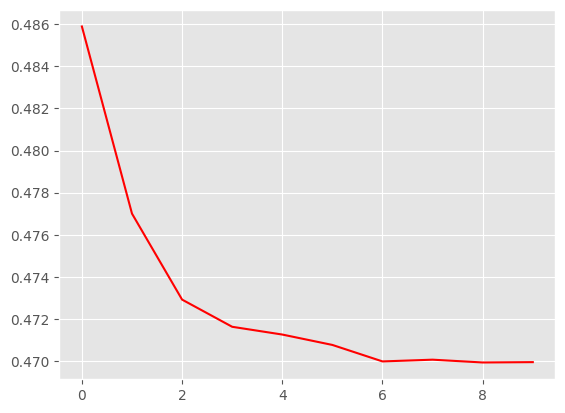

In [ ]:
train_acc = model.evaluate(X_train, trainY, batch_size=32)[1]
test_acc = model.evaluate(X_test, testY, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = hist.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [ ]:
#ModelMetrics(X_test, testY, model)

#predsigmoid = (model.predict(X_test)>0.5).astype(int)
#predrelu=(modelrelu.predict(X_test)>0.5).astype(int)
#modelsigmoid = load_model('/content/drive/MyDrive/Rohit Work/fnn_model')
#predsigmoid = modelsigmoid.predict(X_test)
predsigmoid = model.predict(X_test)
predrelu = modelrelu.predict(X_test)
predreluadam = modelreluadam.predict(X_test)

for i in range (10):
  print(testY[i],predsigmoid[i],predrelu[i], predreluadam[i])
